# Logistic Regression - Heart Failure Prediction

This notebook builds and evaluates a **Logistic Regression** model for predicting the likelihood of heart failure based on patient health attributes.  

---

## Objective

Use Logistic Regression as a **baseline classifier** to:
- Identify which health factors are most strongly associated with heart failure
- Establish a performance benchmark for comparison with more complex models such as Decision Trees, Random Forests, and Gradient Boosted Trees

---

## Dataset Summary

The dataset contains **918 patient records** and **11 health-related features**, along with a binary target variable:

- **Target:** `HeartDisease` (1 = patient has or is at risk of heart failure, 0 = otherwise)

**Features include:**
- *Age, Sex, ChestPainType, RestingBP, Cholesterol, FastingBS, RestingECG, MaxHR, ExerciseAngina, Oldpeak, ST_Slope*

---

## Overview

1. **Load the dataset** (`dataset/heart.csv`)  
3. **Preprocess features** (encode categorical variables, scale numerical features)  
4. **Train/test split** to evaluate model generalization  
5. **Build and train** a Logistic Regression model  
6. **Evaluate performance** using metrics such as Accuracy, F1-score, and ROC-AUC  
7. **Interpret coefficients** to understand key risk indicators

---

##  Notes

- All preprocessing for this model (encoding, scaling, and splitting) is handled **within this notebook** for simplicity.  
- The same random seed (`random_state=42`) will be used across models to ensure consistent splits and fair performance comparison.  
- Results here will serve as a **baseline** for evaluating more advanced models later in the project.


## Loading the Dataset

We load the dataset from *Kaggle's* **.csv** file to initialize a dataframe (`df`).

Afterwards, we can verify `df` has been populated and observe the structure of the data.

In [1]:
import pandas as pd

df = pd.read_csv("dataset/heart.csv")

df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [2]:
df.shape

(918, 12)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


## Data Preparation and Feature Construction

Now that we’ve verified the dataset’s integrity, we can construct the **feature matrix (`X`)** and **label vector (`y`)** for model training.

We begin by selecting all relevant feature columns from the dataset.  

The target variable, `HeartDisease`, will serve as our label vector (`y`), while the remaining columns form the feature matrix (`X`).


In [4]:
y = df['HeartDisease']
y[::100]

0      0
100    1
200    0
300    1
400    1
500    1
600    0
700    0
800    0
900    1
Name: HeartDisease, dtype: int64

## Feature Scaling

Before training our Logistic Regression model, we need to ensure that all numeric features are on a comparable scale.  

This is important because Logistic Regression is a **gradient-based** model meaning large differences in feature magnitudes can cause certain variables (like `Cholesterol` or `MaxHR`) to dominate the optimization process and skew the model’s learning.

We use **StandardScaler** from *scikit-learn* to standardize numeric columns by removing the mean and scaling each feature to unit variance.

This transformation centers all numeric features around zero and ensures they contribute proportionally to the model’s coefficients.  

> **Note:** Categorical variables will be handled separately through one-hot encoding and are *NOT* affected by scaling.


In [5]:
from sklearn.preprocessing import StandardScaler

num_feature_cols = ['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak']

scaler = StandardScaler()
scaled_array = scaler.fit_transform(df[num_feature_cols])
scaled_df = pd.DataFrame(scaled_array, columns=num_feature_cols)


## Encoding Categorical Features

Several features in this dataset are **categorical** (e.g., `Sex`, `ChestPainType`, `RestingECG`, `ExerciseAngina`, `ST_Slope`), and must be converted into numeric form for Logistic Regression to process them.

We use scikit-learn’s `OneHotEncoder` to transform these categorical columns into binary indicator variables.  
This creates a new set of columns representing each category, allowing the model to learn from categorical distinctions without assuming any ordinal relationship.

> **Note:** We set `sparse_output=False` so that the encoder returns a dense NumPy array, which can easily be converted into a Pandas DataFrame.

Once encoded, we merge the resulting one-hot columns with the numeric features to form the final feature matrix (`X`).  
The target vector (`y`) remains unchanged since it’s already numeric.

In [6]:
from sklearn.preprocessing import OneHotEncoder

cat_feature_cols = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']

# Match with encoded columns
for col in cat_feature_cols:
    print(f"{col}: {df[col].unique()}")

encoder = OneHotEncoder(sparse_output=False)

encoded_array = encoder.fit_transform(df[cat_feature_cols])

# Get column names for the encoded features
encoded_cols = encoder.get_feature_names_out(cat_feature_cols)

# Create a DataFrame for the encoded columns
encoded_df = pd.DataFrame(encoded_array, columns=encoded_cols)

# Combine encoded features with scaled numeric features
X = pd.concat([scaled_df, encoded_df], axis=1)

Sex: ['M' 'F']
ChestPainType: ['ATA' 'NAP' 'ASY' 'TA']
RestingECG: ['Normal' 'ST' 'LVH']
ExerciseAngina: ['N' 'Y']
ST_Slope: ['Up' 'Flat' 'Down']


In [7]:
X.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,Sex_F,Sex_M,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,-1.433140,0.410909,0.825070,-0.551341,1.382928,-0.832432,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
1,-0.478484,1.491752,-0.171961,-0.551341,0.754157,0.105664,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
2,-1.751359,-0.129513,0.770188,-0.551341,-1.525138,-0.832432,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
3,-0.584556,0.302825,0.139040,-0.551341,-1.132156,0.574711,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
4,0.051881,0.951331,-0.034755,-0.551341,-0.581981,-0.832432,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0


In [8]:
print(X.shape)
print(y.value_counts())

(918, 20)
HeartDisease
1    508
0    410
Name: count, dtype: int64


## Splitting the Data for Model Evaluation

To properly assess our Logistic Regression model, we need to separate the dataset into distinct training and evaluation sets.  
This ensures that the model is tested on unseen data and prevents overfitting.

We will explore **two common evaluation strategies**:

1. **Standard Train/Test Split** – a single 80/20 split providing a quick baseline of model performance.  
2. **k-Fold Cross-Validation** – a more robust method that repeatedly trains and tests the model across multiple data partitions.

By comparing results from both approaches, we can evaluate the **stability and consistency** of our model’s predictions and choose the most reliable validation strategy for further tuning.


## Standard Train/Test Split

We begin by establishing a **baseline performance** for our Logistic Regression model using a simple 80/20 train–test split.  
This approach provides an initial benchmark for accuracy and other key metrics before applying more rigorous validation methods such as k-fold cross-validation.

The data is split into **training** and **testing** subsets using `train_test_split`, ensuring that class proportions are preserved through stratification.  

We will use the following parameters: `test_size`=**0.2**, `random_state`=**42**.

Our *test size* indicates that our training dataset will take up 80% of the total dataset while the testing set takes up 20%.

Our *random state* is a seed that allows us to have replicable results when splitting the data.

We then train the Logistic Regression model on the training data and evaluate it on the unseen test data.

Performance is measured using:
- **Accuracy** – overall proportion of correct predictions  
- **Precision, Recall, and F1-s**


In [9]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)



## Training the Logistic Regression Model

With the data prepared, we now split it into **training** and **testing** subsets to evaluate how well the model generalizes to unseen data.  
We use an 80/20 split while preserving class proportions with `stratify=y`.

Next, we initialize and fit a **Logistic Regression** model using the training data, then generate predictions and predicted probabilities for the test set.


In [ ]:
# Initialize and train model
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

# Predictions
y_pred = log_reg.predict(X_test)
y_proba = log_reg.predict_proba(X_test)[:, 1]

## Evaluating Model Performance

We now evaluate the Logistic Regression model using standard classification metrics.  
These metrics show how accurately the model predicts heart disease cases in the test set.

We will compute:
- **Accuracy:** the proportion of total predictions that are correct  
- **Precision:** the proportion of positive predictions that are actually correct  
- **Recall:** the proportion of actual positive cases correctly identified  
- **F1-Score:** the harmonic mean of precision and recall, balancing both measures

These values provide an overall sense of the model’s effectiveness and reliability.


In [25]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Create a formatted results DataFrame
baseline_results = pd.DataFrame({
    'Model': ['Logistic Regression'],
    'Accuracy': [accuracy],
    'Precision': [precision],
    'Recall': [recall],
    'F1-Score': [f1]
})

display(baseline_results.round(3))

,Model,Accuracy,Precision,Recall,F1-Score
0,Logistic Regression,0.886,0.872,0.931,0.9


## Training the Logistic Regression Model with k-Fold Cross-Validation

To obtain a more reliable estimate of model performance, we now evaluate Logistic Regression using **k-Fold Cross-Validation**.  

Unlike a single train/test split, k-Fold CV divides the dataset into *k* equal parts (or *folds*) and repeatedly trains and tests the model *k* times, each time using a different fold as the test set.  

This approach helps measure how consistently the model performs across different subsets of the data and reduces the effect of any one random split.  

For this experiment, we use **10 folds**, which is a common balance.
During each fold, we record several standard classification metrics: **accuracy**, **precision**, **recall**, and **F1-score**.

The individual fold results allow us to observe variation across splits, while the averaged metrics summarize the model’s overall effectiveness.


In [21]:
from sklearn.model_selection import cross_validate
import numpy as np

# Initialize model
log_reg_cv = LogisticRegression(max_iter=1000)

# Define metrics to collect
scoring = ['accuracy', 'precision', 'recall', 'f1']

# Perform 10-fold cross-validation
cv_results = cross_validate(log_reg_cv, X, y, cv=10, scoring=scoring)

# Convert results to DataFrame
cv_metrics = pd.DataFrame({
    'Fold': range(1, 11),
    'Accuracy': cv_results['test_accuracy'],
    'Precision': cv_results['test_precision'],
    'Recall': cv_results['test_recall'],
    'F1-Score': cv_results['test_f1']
})

display(cv_metrics.round(3))

# Summary table showing mean and standard deviation
cv_summary = pd.DataFrame({
    'Model': ['Logistic Regression'],
    'Mean Accuracy': [np.mean(cv_results['test_accuracy'])],
    'Mean Precision': [np.mean(cv_results['test_precision'])],
    'Mean Recall': [np.mean(cv_results['test_recall'])],
    'Mean F1-Score': [np.mean(cv_results['test_f1'])]
})

display(cv_summary.round(3))


,Fold,Accuracy,Precision,Recall,F1-Score
0,1,0.826,0.907,0.765,0.830
1,2,0.924,0.958,0.902,0.929
2,3,0.870,0.915,0.843,0.878
3,4,0.946,0.960,0.941,0.950
4,5,0.870,0.820,0.980,0.893
5,6,0.848,0.785,1.000,0.879
6,7,0.880,0.833,0.980,0.901
7,8,0.837,0.875,0.824,0.848
8,9,0.725,0.745,0.760,0.752
9,10,0.791,0.878,0.720,0.791


,Model,Mean Accuracy,Mean Precision,Mean Recall,Mean F1-Score
0,Logistic Regression,0.852,0.868,0.872,0.865


## Evaluation and Comparison of Results

With both evaluation methods completed, we can now compare the model’s performance using the **standard train/test split** and the **10-fold cross-validation** results.

The train/test split provides a quick baseline accuracy on one division of the data, while the k-fold method offers a more robust estimate by averaging performance across multiple subsets. 

Comparing these results helps us determine whether the model’s accuracy is consistent or sensitive to how the data is split.

We will summarize both results side by side and visualize them to highlight any differences in performance stability and overall accuracy.


,Method,Accuracy,Precision,Recall,F1-Score
0,Train/Test Split,0.886,0.872,0.931,0.900
1,10-Fold Cross-Validation,0.852,0.868,0.872,0.865


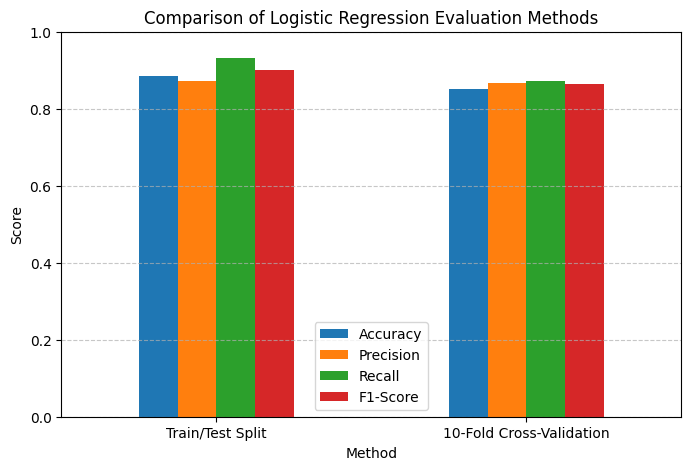

In [27]:
import matplotlib.pyplot as plt

# Combine baseline and k-fold summaries into one DataFrame
comparison_df = pd.DataFrame({
    'Method': ['Train/Test Split', '10-Fold Cross-Validation'],
    'Accuracy': [baseline_results['Accuracy'][0], np.mean(cv_results['test_accuracy'])],
    'Precision': [baseline_results['Precision'][0], np.mean(cv_results['test_precision'])],
    'Recall': [baseline_results['Recall'][0], np.mean(cv_results['test_recall'])],
    'F1-Score': [baseline_results['F1-Score'][0], np.mean(cv_results['test_f1'])]
})

display(comparison_df.round(3))

# Bar chart comparison
comparison_df.set_index('Method')[['Accuracy', 'Precision', 'Recall', 'F1-Score']].plot(
    kind='bar', figsize=(8, 5), rot=0
)
plt.title('Comparison of Logistic Regression Evaluation Methods')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Interpreting Evaluation Results

The comparison shows that the **train/test split** produced slightly higher scores across the board against **10-fold cross-validation**.

This small difference is expected. A single train/test split can sometimes yield optimistic results depending on how the data is divided, while cross-validation provides a more stable estimate by averaging performance over multiple folds.

Overall, the Logistic Regression model demonstrates consistent performance across both evaluation methods, with only minor variation in precision, recall, and F1-score. 

This indicates that the model generalizes well and is not overly dependent on any specific data partition.


## Conclusion

In this notebook, we implemented and evaluated a **Logistic Regression** model to predict heart disease based on a set of clinical and demographic features. 

After preparing and scaling the dataset, we tested the model using both a **standard 80/20 train–test split** and **10-fold cross-validation**.

The results show that Logistic Regression performs reliably, achieving strong accuracy, precision, recall, and F1-scores across both methods.  
While the train/test split reported slightly higher performance, the cross-validation results provide a more dependable estimate of the model’s true generalization ability.

These findings suggest that Logistic Regression is an effective baseline classifier for this dataset.  
Future work could involve experimenting with additional models such as Decision Trees, Random Forests, or Gradient Boosted Trees to compare non-linear approaches and evaluate whether they can capture more complex relationships in the data.

